In [ ]:
!pip install transformers

In [ ]:
!pip install sentencepiece

In [16]:
import tensorflow as tf
import numpy as np
import pandas as pd
from transformers import *
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import sentencepiece as spm

In [4]:
train = pd.read_csv('/content/drive/MyDrive/우울부정키워드.CSV', encoding='cp949')

In [6]:
train['감정'] = train['감정'].replace('우울', 1)
train['감정'] = train['감정'].replace('부정', 0)

In [7]:
train.head()

,발화문,감정
0,키우던 고양이가 죽어서 우울해,1
1,옛날에 키우던 고양이가 생각나서 울적하네,1
2,요즘 되는일도 없고 울적하다,1
3,지원하는 곳마다 떨어져.. 우울해,1
4,왠지 모르게 기분이 다운되네,1


In [8]:
import logging
import os
import unicodedata
from shutil import copyfile

from transformers import PreTrainedTokenizer


logger = logging.getLogger(__name__)

VOCAB_FILES_NAMES = {"vocab_file": "tokenizer_78b3253a26.model",
                     "vocab_txt": "vocab.txt"}

PRETRAINED_VOCAB_FILES_MAP = {
    "vocab_file": {
        "monologg/kobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert/tokenizer_78b3253a26.model",
        "monologg/kobert-lm": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert-lm/tokenizer_78b3253a26.model",
        "monologg/distilkobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/distilkobert/tokenizer_78b3253a26.model"
    },
    "vocab_txt": {
        "monologg/kobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert/vocab.txt",
        "monologg/kobert-lm": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert-lm/vocab.txt",
        "monologg/distilkobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/distilkobert/vocab.txt"
    }
}

PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES = {
    "monologg/kobert": 512,
    "monologg/kobert-lm": 512,
    "monologg/distilkobert": 512
}

PRETRAINED_INIT_CONFIGURATION = {
    "monologg/kobert": {"do_lower_case": False},
    "monologg/kobert-lm": {"do_lower_case": False},
    "monologg/distilkobert": {"do_lower_case": False}
}

SPIECE_UNDERLINE = u'▁'


class KoBertTokenizer(PreTrainedTokenizer):
    """
        SentencePiece based tokenizer. Peculiarities:
            - requires `SentencePiece <https://github.com/google/sentencepiece>`_
    """
    vocab_files_names = VOCAB_FILES_NAMES
    pretrained_vocab_files_map = PRETRAINED_VOCAB_FILES_MAP
    pretrained_init_configuration = PRETRAINED_INIT_CONFIGURATION
    max_model_input_sizes = PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES

    def __init__(
            self,
            vocab_file,
            vocab_txt,
            do_lower_case=False,
            remove_space=True,
            keep_accents=False,
            unk_token="[UNK]",
            sep_token="[SEP]",
            pad_token="[PAD]",
            cls_token="[CLS]",
            mask_token="[MASK]",
            **kwargs):
        super().__init__(
            unk_token=unk_token,
            sep_token=sep_token,
            pad_token=pad_token,
            cls_token=cls_token,
            mask_token=mask_token,
            **kwargs
        )

        # Build vocab
        self.token2idx = dict()
        self.idx2token = []
        with open(vocab_txt, 'r', encoding='utf-8') as f:
            for idx, token in enumerate(f):
                token = token.strip()
                self.token2idx[token] = idx
                self.idx2token.append(token)

        try:
            import sentencepiece as spm
        except ImportError:
            logger.warning("You need to install SentencePiece to use KoBertTokenizer: https://github.com/google/sentencepiece"
                           "pip install sentencepiece")

        self.do_lower_case = do_lower_case
        self.remove_space = remove_space
        self.keep_accents = keep_accents
        self.vocab_file = vocab_file
        self.vocab_txt = vocab_txt

        self.sp_model = spm.SentencePieceProcessor()
        self.sp_model.Load(vocab_file)

    @property
    def vocab_size(self):
        return len(self.idx2token)

    def get_vocab(self):
        return dict(self.token2idx, **self.added_tokens_encoder)

    def __getstate__(self):
        state = self.__dict__.copy()
        state["sp_model"] = None
        return state

    def __setstate__(self, d):
        self.__dict__ = d
        try:
            import sentencepiece as spm
        except ImportError:
            logger.warning("You need to install SentencePiece to use KoBertTokenizer: https://github.com/google/sentencepiece"
                           "pip install sentencepiece")
        self.sp_model = spm.SentencePieceProcessor()
        self.sp_model.Load(self.vocab_file)

    def preprocess_text(self, inputs):
        if self.remove_space:
            outputs = " ".join(inputs.strip().split())
        else:
            outputs = inputs
        outputs = outputs.replace("``", '"').replace("''", '"')

        if not self.keep_accents:
            outputs = unicodedata.normalize('NFKD', outputs)
            outputs = "".join([c for c in outputs if not unicodedata.combining(c)])
        if self.do_lower_case:
            outputs = outputs.lower()

        return outputs

    def _tokenize(self, text, return_unicode=True, sample=False):
        """ Tokenize a string. """
        text = self.preprocess_text(text)

        if not sample:
            pieces = self.sp_model.EncodeAsPieces(text)
        else:
            pieces = self.sp_model.SampleEncodeAsPieces(text, 64, 0.1)
        new_pieces = []
        for piece in pieces:
            if len(piece) > 1 and piece[-1] == str(",") and piece[-2].isdigit():
                cur_pieces = self.sp_model.EncodeAsPieces(piece[:-1].replace(SPIECE_UNDERLINE, ""))
                if piece[0] != SPIECE_UNDERLINE and cur_pieces[0][0] == SPIECE_UNDERLINE:
                    if len(cur_pieces[0]) == 1:
                        cur_pieces = cur_pieces[1:]
                    else:
                        cur_pieces[0] = cur_pieces[0][1:]
                cur_pieces.append(piece[-1])
                new_pieces.extend(cur_pieces)
            else:
                new_pieces.append(piece)

        return new_pieces

    def _convert_token_to_id(self, token):
        """ Converts a token (str/unicode) in an id using the vocab. """
        return self.token2idx.get(token, self.token2idx[self.unk_token])

    def _convert_id_to_token(self, index, return_unicode=True):
        """Converts an index (integer) in a token (string/unicode) using the vocab."""
        return self.idx2token[index]

    def convert_tokens_to_string(self, tokens):
        """Converts a sequence of tokens (strings for sub-words) in a single string."""
        out_string = "".join(tokens).replace(SPIECE_UNDERLINE, " ").strip()
        return out_string

    def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
        """
        Build model inputs from a sequence or a pair of sequence for sequence classification tasks
        by concatenating and adding special tokens.
        A KoBERT sequence has the following format:
            single sequence: [CLS] X [SEP]
            pair of sequences: [CLS] A [SEP] B [SEP]
        """
        if token_ids_1 is None:
            return [self.cls_token_id] + token_ids_0 + [self.sep_token_id]
        cls = [self.cls_token_id]
        sep = [self.sep_token_id]
        return cls + token_ids_0 + sep + token_ids_1 + sep

    def get_special_tokens_mask(self, token_ids_0, token_ids_1=None, already_has_special_tokens=False):
        """
        Retrieves sequence ids from a token list that has no special tokens added. This method is called when adding
        special tokens using the tokenizer ``prepare_for_model`` or ``encode_plus`` methods.
        Args:
            token_ids_0: list of ids (must not contain special tokens)
            token_ids_1: Optional list of ids (must not contain special tokens), necessary when fetching sequence ids
                for sequence pairs
            already_has_special_tokens: (default False) Set to True if the token list is already formated with
                special tokens for the model
        Returns:
            A list of integers in the range [0, 1]: 0 for a special token, 1 for a sequence token.
        """

        if already_has_special_tokens:
            if token_ids_1 is not None:
                raise ValueError(
                    "You should not supply a second sequence if the provided sequence of "
                    "ids is already formated with special tokens for the model."
                )
            return list(map(lambda x: 1 if x in [self.sep_token_id, self.cls_token_id] else 0, token_ids_0))

        if token_ids_1 is not None:
            return [1] + ([0] * len(token_ids_0)) + [1] + ([0] * len(token_ids_1)) + [1]
        return [1] + ([0] * len(token_ids_0)) + [1]

    def create_token_type_ids_from_sequences(self, token_ids_0, token_ids_1=None):
        """
        Creates a mask from the two sequences passed to be used in a sequence-pair classification task.
        A KoBERT sequence pair mask has the following format:
        0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
        | first sequence    | second sequence
        if token_ids_1 is None, only returns the first portion of the mask (0's).
        """
        sep = [self.sep_token_id]
        cls = [self.cls_token_id]
        if token_ids_1 is None:
            return len(cls + token_ids_0 + sep) * [0]
        return len(cls + token_ids_0 + sep) * [0] + len(token_ids_1 + sep) * [1]

    def save_vocabulary(self, save_directory):
        """ Save the sentencepiece vocabulary (copy original file) and special tokens file
            to a directory.
        """
        if not os.path.isdir(save_directory):
            logger.error("Vocabulary path ({}) should be a directory".format(save_directory))
            return

        # 1. Save sentencepiece model
        out_vocab_model = os.path.join(save_directory, VOCAB_FILES_NAMES["vocab_file"])

        if os.path.abspath(self.vocab_file) != os.path.abspath(out_vocab_model):
            copyfile(self.vocab_file, out_vocab_model)

        # 2. Save vocab.txt
        index = 0
        out_vocab_txt = os.path.join(save_directory, VOCAB_FILES_NAMES["vocab_txt"])
        with open(out_vocab_txt, "w", encoding="utf-8") as writer:
            for token, token_index in sorted(self.token2idx.items(), key=lambda kv: kv[1]):
                if index != token_index:
                    logger.warning(
                        "Saving vocabulary to {}: vocabulary indices are not consecutive."
                        " Please check that the vocabulary is not corrupted!".format(out_vocab_txt)
                    )
                    index = token_index
                writer.write(token + "\n")
                index += 1

        return out_vocab_model, out_vocab_txt

In [9]:
tokenizer = KoBertTokenizer.from_pretrained('monologg/kobert')

In [12]:
def convert_data(data_df):
    global tokenizer
    
    SEQ_LEN = 64 #SEQ_LEN : 버트에 들어갈 인풋의 길이
    
    tokens, masks, segments, targets = [], [], [], []
    
    for i in tqdm(range(len(data_df))):
        # token : 문장을 토큰화함
        token = tokenizer.encode(data_df[DATA_COLUMN][i], truncation=True, padding='max_length', max_length=SEQ_LEN)
       
        # 마스크는 토큰화한 문장에서 패딩이 아닌 부분은 1, 패딩인 부분은 0으로 통일
        num_zeros = token.count(0)
        mask = [1]*(SEQ_LEN-num_zeros) + [0]*num_zeros
        
        # 문장의 전후관계를 구분해주는 세그먼트는 문장이 1개밖에 없으므로 모두 0
        segment = [0]*SEQ_LEN

        # 버트 인풋으로 들어가는 token, mask, segment를 tokens, segments에 각각 저장
        tokens.append(token)
        masks.append(mask)
        segments.append(segment)
        
        # 정답(긍정 : 1 부정 0)을 targets 변수에 저장해 줌
        targets.append(data_df[LABEL_COLUMN][i])

    # tokens, masks, segments, 정답 변수 targets를 numpy array로 지정    
    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    targets = np.array(targets)

    return [tokens, masks, segments], targets

# 위에 정의한 convert_data 함수를 불러오는 함수를 정의
def load_data(pandas_dataframe):
    data_df = pandas_dataframe
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
    data_df[LABEL_COLUMN] = data_df[LABEL_COLUMN].astype(int)
    data_x, data_y = convert_data(data_df)
    return data_x, data_y

SEQ_LEN = 64
BATCH_SIZE = 32
# 긍부정 문장을 포함하고 있는 칼럼
DATA_COLUMN = "발화문"
# 긍정인지 부정인지를 (1=긍정,0=부정) 포함하고 있는 칼럼
LABEL_COLUMN = "감정"

# train 데이터를 버트 인풋에 맞게 변환
train_x, train_y = load_data(train)

100%|██████████| 795/795 [00:00<00:00, 4253.16it/s]


In [17]:
model = TFBertModel.from_pretrained("monologg/kobert", from_pt=True)
# 토큰 인풋, 마스크 인풋, 세그먼트 인풋 정의
token_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_word_ids')
mask_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_masks')
segment_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_segment')
# 인풋이 [토큰, 마스크, 세그먼트]인 모델 정의
bert_outputs = model([token_inputs, mask_inputs, segment_inputs])

All PyTorch model weights were used when initializing TFBertModel.

All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

In [18]:
bert_outputs = bert_outputs[1]

In [19]:
# Rectified Adam 옵티마이저 사용
!pip install tensorflow_addons
import tensorflow_addons as tfa
# 총 batch size * 4 epoch = 2344 * 4
opt = tfa.optimizers.RectifiedAdam(lr=5.0e-5, total_steps = 2344*2, warmup_proportion=0.1, min_lr=1e-5, epsilon=1e-08, clipnorm=1.0)

     |████████████████████████████████| 686kB 4.3MB/s 


In [20]:
sentiment_drop = tf.keras.layers.Dropout(0.5)(bert_outputs)
sentiment_first = tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02))(sentiment_drop)
sentiment_model = tf.keras.Model([token_inputs, mask_inputs, segment_inputs], sentiment_first)
sentiment_model.compile(optimizer=opt, loss=tf.keras.losses.BinaryCrossentropy(), metrics = ['accuracy'])

In [21]:
sentiment_model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_segment (InputLayer)      [(None, 64)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 92186880    input_word_ids[0][0]             
                                                                 input_masks[0][0]            

In [26]:
history = sentiment_model.fit(train_x, train_y, epochs=10, shuffle=True, batch_size=64)

Epoch 1/10
13/13 [==============================] - 21s 2s/step - loss: 0.6326 - accuracy: 0.7283
Epoch 2/10
13/13 [==============================] - 21s 2s/step - loss: 0.5953 - accuracy: 0.8214
Epoch 3/10
13/13 [==============================] - 21s 2s/step - loss: 0.5630 - accuracy: 0.8428
Epoch 4/10
13/13 [==============================] - 21s 2s/step - loss: 0.5363 - accuracy: 0.8591
Epoch 5/10
13/13 [==============================] - 21s 2s/step - loss: 0.5043 - accuracy: 0.8654
Epoch 6/10
13/13 [==============================] - 21s 2s/step - loss: 0.4729 - accuracy: 0.8704
Epoch 7/10
13/13 [==============================] - 21s 2s/step - loss: 0.4510 - accuracy: 0.8730
Epoch 8/10
13/13 [==============================] - 21s 2s/step - loss: 0.4236 - accuracy: 0.8767
Epoch 9/10
13/13 [==============================] - 21s 2s/step - loss: 0.3987 - accuracy: 0.8805
Epoch 10/10
13/13 [==============================] - 21s 2s/step - loss: 0.3623 - accuracy: 0.8931


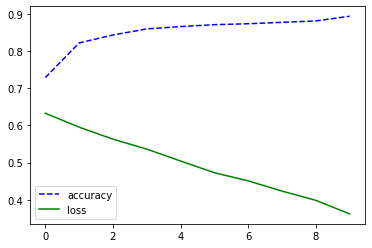

In [28]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], 'b--', label='accuracy')
plt.plot(history.history['loss'], 'g-', label='loss')
plt.legend()
plt.show()

In [31]:
def sentence_convert_data(data):
    global tokenizer
    tokens, masks, segments = [], [], []
    token = tokenizer.encode(data, max_length=SEQ_LEN, truncation=True, padding='max_length')
    
    num_zeros = token.count(0) 
    mask = [1]*(SEQ_LEN-num_zeros) + [0]*num_zeros 
    segment = [0]*SEQ_LEN

    tokens.append(token)
    segments.append(segment)
    masks.append(mask)

    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    return [tokens, masks, segments]

def evaluation_predict(sentence):
    data_x = sentence_convert_data(sentence)
    predict = sentiment_model.predict(data_x)
    predict_value = np.ravel(predict)
    predict_answer = np.round(predict_value,0).item()
    
    if predict_answer == 0:
      print("(부정 확률 : %.2f) 우울하지 않음" % (1-predict_value))
    elif predict_answer == 1:
      print("(긍정 확률 : %.2f) 우울" % predict_value)


In [34]:
evaluation_predict('저는요 잘버티고있다고 생각했는데요 전부다 저를 위하는 말일텐데 왜이렇게 철렁할까요 평소라면 웃으면서 받아줘야할 농담들이 너무 상처를주고 저를 괴롭게 만들어요 가슴이 쿡쿡찌르듯이 아파요 제가 힘들어서 상담기관을 찾아간걸 아는 언니가 제게 했던 말들이 장난일텐데 이런말을 하는게 너무 속상해요 학교 갈생각하면 괴롭고요 답답해요 더이상 이런생활을 하는게 지쳐요 더이상 살기위해 자해하는것도 지치구요 웃으면 다니는것도 지치구요 살아있는것 자체가 지치기시작해요')

(부정 확률 : 0.62) 우울하지 않음


In [35]:
evaluation_predict('죽고 싶어')

(긍정 확률 : 0.82) 우울


In [37]:
evaluation_predict('더이상 살고 싶지 않아')


(부정 확률 : 0.63) 우울하지 않음


출처: https://github.com/kimwoonggon/publicservant_AI/blob/master/2_(Hugging+%ED%95%9C%EA%B8%80BERT)%EB%84%A4%EC%9D%B4%EB%B2%84%20%EA%B0%90%EC%84%B1%EB%B6%84%EC%84%9D%2090%25%20%EB%8B%AC%EC%84%B1%ED%95%98%EA%B8%B0.ipynb

In [3]:
from transformers import TFElectraModel

model = TFElectraModel.from_pretrained("monologg/koelectra-base-v3-discriminator", from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFElectraModel: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias', 'electra.embeddings.position_ids', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing TFElectraModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFElectraModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further train

In [5]:
import pandas as pd

train = pd.read_csv('/content/drive/MyDrive/우울부정키워드.CSV', encoding='cp949')

train['감정'] = train['감정'].replace('우울', 1)
train['감정'] = train['감정'].replace('부정', 0)

In [11]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator")

In [20]:
def tokenize_function(examples):
    return tokenizer(examples["발화문"], 
                     return_tensors='pt',
                     pad_to_max_length=True, 
                     truncation=True,
                     max_length=256)

tokenized_datasets = tokenize_function(train['발화문'])

KeyError: ignored